In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class TrafficSignNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # CONV => RELU => BN => POOL
        model.add(Conv2D(8, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # second set of FC => RELU layers
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [6]:
def load_split(basePath, csvPath, bdd = 'other'):
    # initialize the list of data and labels
    data = []
    labels = []

    # load the contents of the CSV file, remove the first line (since
    # it contains the CSV header), and shuffle the rows (otherwise
    # all examples of a particular class will be in sequential order)
    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)

    # loop over the rows of the CSV file
    for (i, row) in enumerate(rows):
        # check to see if we should show a status update
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))

        # split the row into components and then grab the class ID
        # and image path
        (label, imagePath) = row.strip().split(",")[-2:]
        # derive the full path to the image file and load it
        imagePath = os.path.sep.join([basePath, imagePath])
        
        image = io.imread(imagePath)

        # resize the image to be 32x32 pixels, ignoring aspect ratio,
        # and then perform Contrast Limited Adaptive Histogram
        # Equalization (CLAHE)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        # update the list of data and labels, respectively
        label_100k = ['0','1','2','3', '4', '5', '6', '7', '8']
        label_other = ['0','1','2','3', '4', '5', '7', '8', '43']
        
        if bdd == '100k':
            label_bdd = label_100k
        else:
            label_bdd = label_other
        if label in label_bdd:
            data.append(image)
            labels.append(int(label))

        if np.shape(data)[0] % 1000 == 0:
            print("[INFO] Added {} training images".format(i))

    # convert the data and labels to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)



    # return a tuple of the data and labels
    return (data, labels)

In [4]:
# Danger signs
danger_signs = np.array([
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "Roundabout mandatory"
])

# Mandatory signs
mandatory_signs = np.array([
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No entry",
    "Roundabout mandatory",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory"
])

# Prohibitory signs
prohibitory_signs = np.array([
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Vehicles over 3.5 metric tons prohibited",
    "No vehicles",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
])

speed_limits = np.array([
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "Speed limit (90km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
])


labelNames = np.array([
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
])

# NOTES : I need to add a "other" class to the dataset, this mean that I need to create images that are not in the dataset
# I want to create a model for each big class (prohibitory, mandatory, danger)
# If this doesn't work, I will try to add data that are from CARLA simulator


In [7]:
# Main path
main_path_EVO = os.path.sep.join(["images", "EVO"])
main_path_carla = os.path.sep.join(["images", "carla"])
main_path_100k = os.path.sep.join(["images", "100k"])

# derive the path to the training and testing CSV files
test_carla = os.path.sep.join(["images", "carla", "labels.csv"])
trainPath = os.path.sep.join(["TS_data/", "Train.csv"])
testPath = os.path.sep.join(["TS_data/", "Test.csv"])
test_EVOPath = os.path.sep.join(["images/EVO/", "Test.csv"])
test_100kPath = os.path.sep.join(["images/100k/", "labels.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(test_100k_X, test_100k_Y) = load_split(main_path_100k, test_100kPath, '100k')
(test_X_carla, test_Y_carla) = load_split(main_path_carla, test_carla)
(testX, testY) = load_split("TS_data", testPath)
(trainX, trainY) = load_split("TS_data", trainPath)
(test_EVO_X, test_EVO_Y) = load_split(main_path_EVO, test_EVOPath)

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
test_EVO_X = test_EVO_X.astype("float32") / 255.0
test_X_carla = test_X_carla.astype("float32") / 255.0
test_100k_X = test_100k_X.astype("float32") / 255.0

[INFO] loading training and testing data...
[INFO] Added 999 training images
[INFO] processed 1000 total images
[INFO] Added 1999 training images
[INFO] processed 2000 total images
[INFO] Added 2999 training images
[INFO] processed 3000 total images
[INFO] Added 3999 training images
[INFO] processed 4000 total images
[INFO] Added 0 training images
[INFO] Added 1 training images
[INFO] Added 2 training images
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] Added 3085 training images
[INFO] Added 3086 training images
[INFO] Added 3087 training images
[INFO] Added 3088 training images
[INFO] Added 3089 training images
[INFO] Added 3090 training images
[INFO] Added 3091 training images
[INFO] Added 3092 training images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] Added 6203 training images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[I

In [13]:
print(trainX.shape)
print(test_100k_X.shape)
print(testX.shape)
print(test_X_carla.shape)
print(test_EVO_X.shape)

(12780, 32, 32, 3)
(4627, 32, 32, 3)
(4170, 32, 32, 3)
(353, 32, 32, 3)
(36, 32, 32, 3)


In [14]:
# one-hot encode the training and testing labels
numLabels = len(np.unique(test_100k_Y))

trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)
test_EVO_Y = to_categorical(test_EVO_Y, numLabels)
# In the carla dataset, there is a class that is not in the dataset (90 km/h)
test_X_carla[test_Y_carla == 43] = 6
test_Y_carla[test_Y_carla == 43] = 6
test_Y_carla = to_categorical(test_Y_carla, numLabels)
test_100k_Y = to_categorical(test_100k_Y, numLabels)

In [15]:
# Split the training data into training and validation data
from sklearn.model_selection import train_test_split

trainX = np.concatenate((trainX, test_100k_X), axis=0)
trainY = np.concatenate((trainY, test_100k_Y), axis=0)

trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=0)

print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)
print(test_EVO_X.shape, test_EVO_Y.shape)
print(test_X_carla.shape, test_Y_carla.shape)

(13925, 32, 32, 3) (13925, 9)
(3482, 32, 32, 3) (3482, 9)
(4170, 32, 32, 3) (4170, 9)
(36, 32, 32, 3) (36, 9)
(353, 32, 32, 3) (353, 9)


In [16]:
# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = trainY.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]


print(classWeight)

{0: 9.061644, 1: 1.1838926, 2: 1.0, 3: 1.4765625, 4: 1.5592221, 5: 1.2005445, 6: 58.8, 7: 1.5778176, 8: 1.9790576}


In [37]:
# Since we only have a small dataset from carla, we will add it to the validation dataset
# this should allow the model to have a better accuracy on a new carla dataset

valX = np.row_stack((valX, test_X_carla))
valY = np.row_stack((valY, test_Y_carla))

# shuffle
import random
random.seed(1)
random.shuffle(valX)
random.shuffle(valY)

In [47]:
print(valX.shape[0])
print(trainX.shape[0])

3482
13925


In [9]:
# Drawing the learning rate evolution in function of the number of epochs

# draw function lr_i = initial_learning_rate * decay_rate^(i/decay_steps) in function of time
def function(i, decay_rate, initial_learning_rate = INIT_LR, decay_steps = trainX.shape[0] // BS):
    return initial_learning_rate * decay_rate**(i/decay_steps)

i = np.linspace(0, trainX.shape[0] // BS*30, 1000)
lr = np.array(function(i, decay_rate))

In [17]:
NUM_EPOCHS = 10
# 30 20
INIT_LR = 10**(-2)
BS = 64
decay_steps = trainX.shape[0] // BS
decay_rate = 0.5
# 0.8
labelNames = speed_limits

In [18]:
# Grid search
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Add this import

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [10, 20, 30],
    'decay_rate': [0.5, 0.8, 0.95],
}

# Define your scoring metric
scoring = 'accuracy'

# Create the model
def create_model(learning_rate=0.001, decay_rate=0.01):
    # initialize the optimizer and compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,  # Make sure you have decay_steps defined somewhere
        decay_rate=decay_rate)

    opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)
    model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

# Construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Create the KerasClassifier with data augmentation
model = KerasClassifier(build_fn=create_model)

# grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1)
# cross_val_trainX = np.row_stack((trainX, valX))
# cross_val_trainY = np.row_stack((trainY, valY))
# grid_search.fit(cross_val_trainX, cross_val_trainY)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=[(slice(None), slice(None))], verbose=1)
grid_search.fit(trainX, trainY, batch_size=BS, validation_data=(valX, valY), class_weight=classWeight)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
print(best_model)

C:\Users\Shadow\AppData\Local\Temp\ipykernel_8004\2677263024.py:43: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Fitting 1 folds for each of 27 candidates, totalling 27 fits
Epoch 1/10
218/218 [==============================] - 13s 50ms/step - loss: 4.4703 - accuracy: 0.1624 - val_loss: 2.4068 - val_accuracy: 0.0210
Epoch 2/10
218/218 [==============================] - 11s 49ms/step - loss: 3.5470 - accuracy: 0.2228 - val_loss: 2.5677 - val_accuracy: 0.1241
Epoch 3/10
218/218 [==============================] - 11s 49ms/step - loss: 3.1215 - accuracy: 0.2613 - val_loss: 2.7134 - val_accuracy: 0.1195
Epoch 4/10
218/218 [==============================] - 11s 49ms/step - loss: 2.9642 - accuracy: 0.2918 - val_loss: 1.7829 - val_accuracy: 0.3090
Epoch 5/10
218/218 [==============================] - 11s 49ms/step - loss: 2.8946 - accuracy: 0.3026 - val_loss: 1.5557 - val_accuracy: 0.4179
Epoch 6/10
218/218 [==============================] - 11s 49ms/step - loss: 2.8505 - accuracy: 0.3128 - val_loss: 1.5418 - val_accuracy: 0.4245
Epoch 7/10
218/218 [==============================] - 11s 49ms/step - loss:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 14s 52ms/step - loss: 3.6710 - accuracy: 0.1992 - val_loss: 2.4151 - val_accuracy: 0.0210
Epoch 2/10
218/218 [==============================] - 11s 50ms/step - loss: 2.2825 - accuracy: 0.4324 - val_loss: 2.4888 - val_accuracy: 0.1238
Epoch 3/10
218/218 [==============================] - 11s 50ms/step - loss: 1.2792 - accuracy: 0.6738 - val_loss: 1.3105 - val_accuracy: 0.4632
Epoch 4/10
218/218 [==============================] - 11s 50ms/step - loss: 0.9433 - accuracy: 0.7651 - val_loss: 0.4617 - val_accuracy: 0.8455
Epoch 5/10
218/218 [==============================] - 11s 50ms/step - loss: 0.7664 - accuracy: 0.8105 - val_loss: 0.3837 - val_accuracy: 0.8708
Epoch 6/10
218/218 [==============================] - 11s 50ms/step - loss: 0.7116 - accuracy: 0.8236 - val_loss: 0.3594 - val_accuracy: 0.8788
Epoch 7/10
218/218 [==============================] - 11s 50ms/step - loss: 0.6585 - accuracy: 0.8373 - val_loss: 0.3353 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 13s 49ms/step - loss: 4.9425 - accuracy: 0.1284 - val_loss: 2.9090 - val_accuracy: 0.1344
Epoch 2/10
218/218 [==============================] - 10s 48ms/step - loss: 3.6833 - accuracy: 0.1366 - val_loss: 2.3281 - val_accuracy: 0.1097
Epoch 3/10
218/218 [==============================] - 10s 48ms/step - loss: 3.4454 - accuracy: 0.1675 - val_loss: 2.3929 - val_accuracy: 0.1160
Epoch 4/10
218/218 [==============================] - 10s 47ms/step - loss: 3.2608 - accuracy: 0.1908 - val_loss: 2.3714 - val_accuracy: 0.1335
Epoch 5/10
218/218 [==============================] - 10s 48ms/step - loss: 3.0034 - accuracy: 0.2368 - val_loss: 1.7963 - val_accuracy: 0.2763
Epoch 6/10
218/218 [==============================] - 10s 48ms/step - loss: 2.7985 - accuracy: 0.2768 - val_loss: 1.6622 - val_accuracy: 0.3185
Epoch 7/10
218/218 [==============================] - 10s 47ms/step - loss: 2.6772 - accuracy: 0.2989 - val_loss: 1.5981 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/20
218/218 [==============================] - 13s 48ms/step - loss: 4.3255 - accuracy: 0.1916 - val_loss: 2.6596 - val_accuracy: 0.1060
Epoch 2/20
218/218 [==============================] - 10s 48ms/step - loss: 3.2606 - accuracy: 0.2875 - val_loss: 2.4378 - val_accuracy: 0.1545
Epoch 3/20
218/218 [==============================] - 10s 48ms/step - loss: 2.7930 - accuracy: 0.3582 - val_loss: 1.8177 - val_accuracy: 0.3139
Epoch 4/20
218/218 [==============================] - 10s 47ms/step - loss: 2.5065 - accuracy: 0.3935 - val_loss: 1.2674 - val_accuracy: 0.5376
Epoch 5/20
218/218 [==============================] - 10s 47ms/step - loss: 2.3933 - accuracy: 0.4200 - val_loss: 1.2062 - val_accuracy: 0.5712
Epoch 6/20
218/218 [==============================] - 10s 47ms/step - loss: 2.3049 - accuracy: 0.4401 - val_loss: 1.1868 - val_accuracy: 0.5841
Epoch 7/20
218/218 [==============================] - 10s 47ms/step - loss: 2.2395 - accuracy: 0.4385 - val_loss: 1.1750 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/20
218/218 [==============================] - 13s 49ms/step - loss: 3.6757 - accuracy: 0.1998 - val_loss: 3.3744 - val_accuracy: 0.1060
Epoch 2/20
218/218 [==============================] - 10s 47ms/step - loss: 2.4580 - accuracy: 0.3820 - val_loss: 2.8887 - val_accuracy: 0.1436
Epoch 3/20
218/218 [==============================] - 10s 47ms/step - loss: 1.5950 - accuracy: 0.6052 - val_loss: 1.4354 - val_accuracy: 0.4675
Epoch 4/20
218/218 [==============================] - 10s 47ms/step - loss: 1.1240 - accuracy: 0.7222 - val_loss: 0.6359 - val_accuracy: 0.7728
Epoch 5/20
218/218 [==============================] - 10s 47ms/step - loss: 0.9351 - accuracy: 0.7742 - val_loss: 0.4743 - val_accuracy: 0.8458
Epoch 6/20
218/218 [==============================] - 10s 47ms/step - loss: 0.8354 - accuracy: 0.8029 - val_loss: 0.4533 - val_accuracy: 0.8576
Epoch 7/20
218/218 [==============================] - 10s 47ms/step - loss: 0.7815 - accuracy: 0.8091 - val_loss: 0.4171 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

218/218 [==============================] - 16s 63ms/step - loss: 5.1548 - accuracy: 0.1237 - val_loss: 3.2032 - val_accuracy: 0.1697
Epoch 2/20
218/218 [==============================] - 12s 55ms/step - loss: 3.7798 - accuracy: 0.1405 - val_loss: 2.5045 - val_accuracy: 0.1304
Epoch 3/20
218/218 [==============================] - 12s 55ms/step - loss: 3.4915 - accuracy: 0.1547 - val_loss: 2.0198 - val_accuracy: 0.1769
Epoch 4/20
218/218 [==============================] - 12s 55ms/step - loss: 3.3877 - accuracy: 0.1645 - val_loss: 1.9729 - val_accuracy: 0.1812
Epoch 5/20
218/218 [==============================] - 12s 55ms/step - loss: 3.3255 - accuracy: 0.1681 - val_loss: 1.9393 - val_accuracy: 0.2165
Epoch 6/20
218/218 [==============================] - 12s 55ms/step - loss: 3.2907 - accuracy: 0.1856 - val_loss: 1.9473 - val_accuracy: 0.2062
Epoch 7/20
218/218 [==============================] - 12s 55ms/step - loss: 3.2762 - accuracy: 0.1767 - val_loss: 1.9568 - val_accuracy: 0.2068
Epo

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 15s 59ms/step - loss: 4.5214 - accuracy: 0.1652 - val_loss: 2.3503 - val_accuracy: 0.1246
Epoch 2/30
218/218 [==============================] - 12s 56ms/step - loss: 3.4921 - accuracy: 0.2428 - val_loss: 2.5756 - val_accuracy: 0.1143
Epoch 3/30
218/218 [==============================] - 12s 56ms/step - loss: 3.0353 - accuracy: 0.3014 - val_loss: 2.0916 - val_accuracy: 0.2863
Epoch 4/30
218/218 [==============================] - 12s 56ms/step - loss: 2.7457 - accuracy: 0.3454 - val_loss: 1.3971 - val_accuracy: 0.5029
Epoch 5/30
218/218 [==============================] - 12s 56ms/step - loss: 2.6387 - accuracy: 0.3605 - val_loss: 1.3531 - val_accuracy: 0.5080
Epoch 6/30
218/218 [==============================] - 12s 56ms/step - loss: 2.6055 - accuracy: 0.3688 - val_loss: 1.3327 - val_accuracy: 0.5129
Epoch 7/30
218/218 [==============================] - 12s 56ms/step - loss: 2.5299 - accuracy: 0.3752 - val_loss: 1.3157 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 14s 56ms/step - loss: 3.8356 - accuracy: 0.1852 - val_loss: 3.8229 - val_accuracy: 0.1238
Epoch 2/30
218/218 [==============================] - 12s 53ms/step - loss: 2.4560 - accuracy: 0.3987 - val_loss: 6.5505 - val_accuracy: 0.1522
Epoch 3/30
218/218 [==============================] - 12s 54ms/step - loss: 1.4093 - accuracy: 0.6522 - val_loss: 1.3321 - val_accuracy: 0.5557
Epoch 4/30
218/218 [==============================] - 12s 53ms/step - loss: 1.0038 - accuracy: 0.7540 - val_loss: 0.5318 - val_accuracy: 0.8159
Epoch 5/30
218/218 [==============================] - 12s 53ms/step - loss: 0.8225 - accuracy: 0.7989 - val_loss: 0.4070 - val_accuracy: 0.8708
Epoch 6/30
218/218 [==============================] - 12s 54ms/step - loss: 0.7190 - accuracy: 0.8246 - val_loss: 0.3767 - val_accuracy: 0.8774
Epoch 7/30
218/218 [==============================] - 12s 54ms/step - loss: 0.6710 - accuracy: 0.8338 - val_loss: 0.3542 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 15s 58ms/step - loss: 5.2974 - accuracy: 0.1390 - val_loss: 2.3175 - val_accuracy: 0.1229
Epoch 2/30
218/218 [==============================] - 13s 58ms/step - loss: 3.6009 - accuracy: 0.1515 - val_loss: 2.1076 - val_accuracy: 0.1516
Epoch 3/30
218/218 [==============================] - 13s 58ms/step - loss: 3.4175 - accuracy: 0.1603 - val_loss: 2.0231 - val_accuracy: 0.1605
Epoch 4/30
218/218 [==============================] - 13s 58ms/step - loss: 3.3444 - accuracy: 0.1639 - val_loss: 2.0038 - val_accuracy: 0.1723
Epoch 5/30
218/218 [==============================] - 13s 58ms/step - loss: 3.3071 - accuracy: 0.1741 - val_loss: 1.9322 - val_accuracy: 0.2025
Epoch 6/30
218/218 [==============================] - 13s 58ms/step - loss: 3.2795 - accuracy: 0.1858 - val_loss: 1.9818 - val_accuracy: 0.1964
Epoch 7/30
218/218 [==============================] - 13s 57ms/step - loss: 3.2783 - accuracy: 0.1842 - val_loss: 1.9564 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 15s 58ms/step - loss: 4.3603 - accuracy: 0.1876 - val_loss: 2.6208 - val_accuracy: 0.1235
Epoch 2/10
218/218 [==============================] - 12s 57ms/step - loss: 3.1962 - accuracy: 0.3155 - val_loss: 2.4920 - val_accuracy: 0.1241
Epoch 3/10
218/218 [==============================] - 12s 57ms/step - loss: 2.4238 - accuracy: 0.4286 - val_loss: 2.1115 - val_accuracy: 0.1330
Epoch 4/10
218/218 [==============================] - 12s 57ms/step - loss: 1.9272 - accuracy: 0.5278 - val_loss: 1.0123 - val_accuracy: 0.6505
Epoch 5/10
218/218 [==============================] - 12s 57ms/step - loss: 1.5438 - accuracy: 0.6133 - val_loss: 0.8959 - val_accuracy: 0.6827
Epoch 6/10
218/218 [==============================] - 12s 57ms/step - loss: 1.3581 - accuracy: 0.6535 - val_loss: 0.6835 - val_accuracy: 0.7740
Epoch 7/10
218/218 [==============================] - 12s 57ms/step - loss: 1.1871 - accuracy: 0.6985 - val_loss: 0.5873 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 16s 63ms/step - loss: 3.4339 - accuracy: 0.2572 - val_loss: 4.5517 - val_accuracy: 0.1522
Epoch 2/10
218/218 [==============================] - 13s 62ms/step - loss: 1.5069 - accuracy: 0.6455 - val_loss: 9.6043 - val_accuracy: 0.1229
Epoch 3/10
218/218 [==============================] - 14s 62ms/step - loss: 0.9375 - accuracy: 0.7800 - val_loss: 0.8002 - val_accuracy: 0.7111
Epoch 4/10
218/218 [==============================] - 14s 62ms/step - loss: 0.6264 - accuracy: 0.8535 - val_loss: 0.2984 - val_accuracy: 0.8960
Epoch 5/10
218/218 [==============================] - 14s 62ms/step - loss: 0.5383 - accuracy: 0.8758 - val_loss: 0.3319 - val_accuracy: 0.8820
Epoch 6/10
218/218 [==============================] - 13s 62ms/step - loss: 0.4734 - accuracy: 0.8966 - val_loss: 0.2150 - val_accuracy: 0.9285
Epoch 7/10
218/218 [==============================] - 13s 62ms/step - loss: 0.3918 - accuracy: 0.9143 - val_loss: 0.1761 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 14s 58ms/step - loss: 5.3001 - accuracy: 0.1303 - val_loss: 2.0998 - val_accuracy: 0.1264
Epoch 2/10
218/218 [==============================] - 12s 56ms/step - loss: 3.8170 - accuracy: 0.1482 - val_loss: 2.0974 - val_accuracy: 0.1516
Epoch 3/10
218/218 [==============================] - 12s 56ms/step - loss: 3.8010 - accuracy: 0.1597 - val_loss: 4.2998 - val_accuracy: 0.1746
Epoch 4/10
218/218 [==============================] - 12s 56ms/step - loss: 3.4639 - accuracy: 0.2168 - val_loss: 1.9728 - val_accuracy: 0.2254
Epoch 5/10
218/218 [==============================] - 12s 56ms/step - loss: 3.4275 - accuracy: 0.2427 - val_loss: 2.1288 - val_accuracy: 0.2343
Epoch 6/10
218/218 [==============================] - 12s 56ms/step - loss: 2.7995 - accuracy: 0.3331 - val_loss: 1.5555 - val_accuracy: 0.3989
Epoch 7/10
218/218 [==============================] - 12s 56ms/step - loss: 2.4537 - accuracy: 0.4116 - val_loss: 1.5979 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

218/218 [==============================] - 17s 68ms/step - loss: 4.2953 - accuracy: 0.1864 - val_loss: 2.3885 - val_accuracy: 0.1060
Epoch 2/20
218/218 [==============================] - 14s 65ms/step - loss: 3.1489 - accuracy: 0.2901 - val_loss: 3.7225 - val_accuracy: 0.1424
Epoch 3/20
218/218 [==============================] - 14s 65ms/step - loss: 2.5331 - accuracy: 0.3892 - val_loss: 3.1834 - val_accuracy: 0.2030
Epoch 4/20
218/218 [==============================] - 14s 65ms/step - loss: 2.0418 - accuracy: 0.4871 - val_loss: 1.0965 - val_accuracy: 0.6249
Epoch 5/20
218/218 [==============================] - 14s 65ms/step - loss: 1.7096 - accuracy: 0.5772 - val_loss: 0.8634 - val_accuracy: 0.7188
Epoch 6/20
218/218 [==============================] - 14s 65ms/step - loss: 1.4749 - accuracy: 0.6296 - val_loss: 0.7578 - val_accuracy: 0.7458
Epoch 7/20
218/218 [==============================] - 14s 65ms/step - loss: 1.3276 - accuracy: 0.6721 - val_loss: 0.6463 - val_accuracy: 0.7866
Epo

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

218/218 [==============================] - 16s 63ms/step - loss: 3.7762 - accuracy: 0.1713 - val_loss: 2.2465 - val_accuracy: 0.1522
Epoch 2/20
218/218 [==============================] - 14s 62ms/step - loss: 2.8738 - accuracy: 0.2897 - val_loss: 1.9969 - val_accuracy: 0.1732
Epoch 3/20
218/218 [==============================] - 14s 62ms/step - loss: 1.7278 - accuracy: 0.5654 - val_loss: 2.1980 - val_accuracy: 0.3291
Epoch 4/20
218/218 [==============================] - 14s 62ms/step - loss: 1.0917 - accuracy: 0.7318 - val_loss: 1.0659 - val_accuracy: 0.6531
Epoch 5/20
218/218 [==============================] - 14s 63ms/step - loss: 0.7320 - accuracy: 0.8223 - val_loss: 0.2963 - val_accuracy: 0.9003
Epoch 6/20
218/218 [==============================] - 14s 62ms/step - loss: 0.5459 - accuracy: 0.8732 - val_loss: 0.2268 - val_accuracy: 0.9225
Epoch 7/20
218/218 [==============================] - 14s 63ms/step - loss: 0.4313 - accuracy: 0.8987 - val_loss: 0.2418 - val_accuracy: 0.9204
Epo

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/20
218/218 [==============================] - 14s 56ms/step - loss: 5.2585 - accuracy: 0.1310 - val_loss: 2.1776 - val_accuracy: 0.0290
Epoch 2/20
218/218 [==============================] - 12s 54ms/step - loss: 4.1122 - accuracy: 0.1267 - val_loss: 2.0927 - val_accuracy: 0.0999
Epoch 3/20
218/218 [==============================] - 12s 54ms/step - loss: 3.8134 - accuracy: 0.1485 - val_loss: 2.0002 - val_accuracy: 0.1950
Epoch 4/20
218/218 [==============================] - 12s 54ms/step - loss: 3.7875 - accuracy: 0.1588 - val_loss: 1.9852 - val_accuracy: 0.2117
Epoch 5/20
218/218 [==============================] - 12s 53ms/step - loss: 3.4143 - accuracy: 0.1843 - val_loss: 2.0228 - val_accuracy: 0.1829
Epoch 6/20
218/218 [==============================] - 12s 54ms/step - loss: 3.2497 - accuracy: 0.2016 - val_loss: 3.8497 - val_accuracy: 0.1246
Epoch 7/20
218/218 [==============================] - 12s 54ms/step - loss: 3.5416 - accuracy: 0.1602 - val_loss: 2.0960 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 15s 60ms/step - loss: 4.5203 - accuracy: 0.1642 - val_loss: 2.2354 - val_accuracy: 0.1824
Epoch 2/30
218/218 [==============================] - 12s 55ms/step - loss: 3.2282 - accuracy: 0.2880 - val_loss: 2.4066 - val_accuracy: 0.1557
Epoch 3/30
218/218 [==============================] - 12s 54ms/step - loss: 2.3665 - accuracy: 0.4141 - val_loss: 1.7391 - val_accuracy: 0.3443
Epoch 4/30
218/218 [==============================] - 12s 54ms/step - loss: 1.8533 - accuracy: 0.5300 - val_loss: 0.8623 - val_accuracy: 0.7096
Epoch 5/30
218/218 [==============================] - 12s 54ms/step - loss: 1.4925 - accuracy: 0.6187 - val_loss: 0.6738 - val_accuracy: 0.7725
Epoch 6/30
218/218 [==============================] - 12s 54ms/step - loss: 1.2574 - accuracy: 0.6829 - val_loss: 0.5646 - val_accuracy: 0.8142
Epoch 7/30
218/218 [==============================] - 12s 54ms/step - loss: 1.0757 - accuracy: 0.7314 - val_loss: 0.4887 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 23s 96ms/step - loss: 3.5212 - accuracy: 0.2592 - val_loss: 5.2165 - val_accuracy: 0.1060
Epoch 2/30
218/218 [==============================] - 21s 96ms/step - loss: 1.7023 - accuracy: 0.5927 - val_loss: 11.4689 - val_accuracy: 0.1235
Epoch 3/30
218/218 [==============================] - 21s 96ms/step - loss: 0.9280 - accuracy: 0.7780 - val_loss: 1.5726 - val_accuracy: 0.4607
Epoch 4/30
218/218 [==============================] - 21s 96ms/step - loss: 0.5881 - accuracy: 0.8636 - val_loss: 0.2447 - val_accuracy: 0.9196
Epoch 5/30
218/218 [==============================] - 21s 96ms/step - loss: 0.4541 - accuracy: 0.8941 - val_loss: 0.1905 - val_accuracy: 0.9414
Epoch 6/30
218/218 [==============================] - 21s 96ms/step - loss: 0.3179 - accuracy: 0.9274 - val_loss: 0.2752 - val_accuracy: 0.9072
Epoch 7/30
218/218 [==============================] - 21s 96ms/step - loss: 0.3493 - accuracy: 0.9194 - val_loss: 0.1597 - val_accuracy

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 22s 92ms/step - loss: 5.4983 - accuracy: 0.1282 - val_loss: 2.6329 - val_accuracy: 0.0210
Epoch 2/30
218/218 [==============================] - 20s 91ms/step - loss: 4.0902 - accuracy: 0.1280 - val_loss: 3.3475 - val_accuracy: 0.1534
Epoch 3/30
218/218 [==============================] - 20s 91ms/step - loss: 3.9060 - accuracy: 0.1321 - val_loss: 4.1423 - val_accuracy: 0.1456
Epoch 4/30
218/218 [==============================] - 20s 91ms/step - loss: 3.7125 - accuracy: 0.1450 - val_loss: 1.9745 - val_accuracy: 0.2085
Epoch 5/30
218/218 [==============================] - 20s 91ms/step - loss: 3.5554 - accuracy: 0.1511 - val_loss: 2.2641 - val_accuracy: 0.1028
Epoch 6/30
218/218 [==============================] - 20s 91ms/step - loss: 3.4202 - accuracy: 0.1810 - val_loss: 1.9606 - val_accuracy: 0.2226
Epoch 7/30
218/218 [==============================] - 20s 91ms/step - loss: 3.2973 - accuracy: 0.2246 - val_loss: 2.9505 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 21s 85ms/step - loss: 4.3536 - accuracy: 0.1800 - val_loss: 2.8475 - val_accuracy: 0.1060
Epoch 2/10
218/218 [==============================] - 18s 84ms/step - loss: 2.9807 - accuracy: 0.3214 - val_loss: 2.6293 - val_accuracy: 0.1531
Epoch 3/10
218/218 [==============================] - 18s 84ms/step - loss: 1.9746 - accuracy: 0.5068 - val_loss: 1.9853 - val_accuracy: 0.2659
Epoch 4/10
218/218 [==============================] - 18s 84ms/step - loss: 1.3967 - accuracy: 0.6445 - val_loss: 0.7540 - val_accuracy: 0.7389
Epoch 5/10
218/218 [==============================] - 18s 85ms/step - loss: 1.0926 - accuracy: 0.7196 - val_loss: 0.5420 - val_accuracy: 0.8053
Epoch 6/10
218/218 [==============================] - 19s 87ms/step - loss: 0.8681 - accuracy: 0.7782 - val_loss: 0.4410 - val_accuracy: 0.8518
Epoch 7/10
218/218 [==============================] - 18s 84ms/step - loss: 0.7053 - accuracy: 0.8249 - val_loss: 0.4300 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 25s 104ms/step - loss: 3.6375 - accuracy: 0.2156 - val_loss: 9.9236 - val_accuracy: 0.1060
Epoch 2/10
218/218 [==============================] - 22s 99ms/step - loss: 2.0469 - accuracy: 0.5022 - val_loss: 2.3144 - val_accuracy: 0.1959
Epoch 3/10
218/218 [==============================] - 21s 96ms/step - loss: 1.1218 - accuracy: 0.7146 - val_loss: 1.4099 - val_accuracy: 0.5009
Epoch 4/10
218/218 [==============================] - 21s 96ms/step - loss: 0.8390 - accuracy: 0.7996 - val_loss: 1.6541 - val_accuracy: 0.5626
Epoch 5/10
218/218 [==============================] - 21s 96ms/step - loss: 0.5587 - accuracy: 0.8715 - val_loss: 0.8097 - val_accuracy: 0.7209
Epoch 6/10
218/218 [==============================] - 21s 96ms/step - loss: 0.5016 - accuracy: 0.8883 - val_loss: 0.6171 - val_accuracy: 0.8102
Epoch 7/10
218/218 [==============================] - 21s 96ms/step - loss: 0.5914 - accuracy: 0.8725 - val_loss: 0.7180 - val_accuracy

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 24s 100ms/step - loss: 5.5677 - accuracy: 0.1391 - val_loss: 4.2081 - val_accuracy: 0.1646
Epoch 2/10
218/218 [==============================] - 22s 99ms/step - loss: 4.6310 - accuracy: 0.1343 - val_loss: 2.0848 - val_accuracy: 0.2022
Epoch 3/10
218/218 [==============================] - 22s 99ms/step - loss: 4.8137 - accuracy: 0.1286 - val_loss: 2.5799 - val_accuracy: 0.0841
Epoch 4/10
218/218 [==============================] - 22s 99ms/step - loss: 4.4543 - accuracy: 0.1350 - val_loss: 3.6340 - val_accuracy: 0.0460
Epoch 5/10
218/218 [==============================] - 22s 99ms/step - loss: 4.2526 - accuracy: 0.1384 - val_loss: 3.4276 - val_accuracy: 0.1930
Epoch 6/10
218/218 [==============================] - 22s 99ms/step - loss: 4.3920 - accuracy: 0.1227 - val_loss: 2.4891 - val_accuracy: 0.1534
Epoch 7/10
218/218 [==============================] - 22s 99ms/step - loss: 4.4184 - accuracy: 0.1324 - val_loss: 2.6545 - val_accuracy

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/20
218/218 [==============================] - 23s 95ms/step - loss: 4.2867 - accuracy: 0.1871 - val_loss: 2.8899 - val_accuracy: 0.1235
Epoch 2/20
218/218 [==============================] - 20s 93ms/step - loss: 3.1360 - accuracy: 0.2919 - val_loss: 2.8144 - val_accuracy: 0.1235
Epoch 3/20
218/218 [==============================] - 20s 94ms/step - loss: 2.2078 - accuracy: 0.4608 - val_loss: 1.5507 - val_accuracy: 0.4325
Epoch 4/20
218/218 [==============================] - 20s 93ms/step - loss: 1.5479 - accuracy: 0.6066 - val_loss: 0.6894 - val_accuracy: 0.7708
Epoch 5/20
218/218 [==============================] - 20s 94ms/step - loss: 1.1143 - accuracy: 0.7217 - val_loss: 0.5006 - val_accuracy: 0.8288
Epoch 6/20
218/218 [==============================] - 20s 94ms/step - loss: 0.8899 - accuracy: 0.7877 - val_loss: 0.7160 - val_accuracy: 0.7616
Epoch 7/20
218/218 [==============================] - 20s 94ms/step - loss: 0.7265 - accuracy: 0.8225 - val_loss: 0.3998 - val_accuracy:

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

218/218 [==============================] - 22s 93ms/step - loss: 3.5615 - accuracy: 0.2609 - val_loss: 6.5953 - val_accuracy: 0.1522
Epoch 2/20
218/218 [==============================] - 20s 92ms/step - loss: 1.9317 - accuracy: 0.5545 - val_loss: 7.0748 - val_accuracy: 0.1060
Epoch 3/20
218/218 [==============================] - 20s 92ms/step - loss: 1.3291 - accuracy: 0.7051 - val_loss: 1.4617 - val_accuracy: 0.5376
Epoch 4/20
218/218 [==============================] - 20s 92ms/step - loss: 0.6236 - accuracy: 0.8547 - val_loss: 0.3585 - val_accuracy: 0.8811
Epoch 5/20
218/218 [==============================] - 20s 92ms/step - loss: 0.4842 - accuracy: 0.8921 - val_loss: 2.0232 - val_accuracy: 0.6017
Epoch 6/20
218/218 [==============================] - 20s 92ms/step - loss: 0.5689 - accuracy: 0.8704 - val_loss: 0.2342 - val_accuracy: 0.9248
Epoch 7/20
218/218 [==============================] - 20s 92ms/step - loss: 0.3278 - accuracy: 0.9245 - val_loss: 0.1293 - val_accuracy: 0.9592
Epo

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/20
218/218 [==============================] - 26s 107ms/step - loss: 5.7990 - accuracy: 0.1232 - val_loss: 152.1773 - val_accuracy: 0.1824
Epoch 2/20
218/218 [==============================] - 23s 107ms/step - loss: 4.8114 - accuracy: 0.1257 - val_loss: 1.9990 - val_accuracy: 0.2016
Epoch 3/20
218/218 [==============================] - 23s 107ms/step - loss: 4.5062 - accuracy: 0.1259 - val_loss: 2.1878 - val_accuracy: 0.1321
Epoch 4/20
218/218 [==============================] - 23s 106ms/step - loss: 4.2805 - accuracy: 0.1295 - val_loss: 2.3114 - val_accuracy: 0.1034
Epoch 5/20
218/218 [==============================] - 23s 106ms/step - loss: 4.0749 - accuracy: 0.1333 - val_loss: 3.0453 - val_accuracy: 0.1361
Epoch 6/20
218/218 [==============================] - 23s 106ms/step - loss: 4.2011 - accuracy: 0.1358 - val_loss: 2.9651 - val_accuracy: 0.0962
Epoch 7/20
218/218 [==============================] - 23s 106ms/step - loss: 4.3524 - accuracy: 0.1352 - val_loss: 2.3988 - val_

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 25s 105ms/step - loss: 4.2629 - accuracy: 0.1963 - val_loss: 2.3782 - val_accuracy: 0.1060
Epoch 2/30
218/218 [==============================] - 23s 104ms/step - loss: 2.8369 - accuracy: 0.3547 - val_loss: 3.2358 - val_accuracy: 0.1522
Epoch 3/30
218/218 [==============================] - 23s 103ms/step - loss: 1.9702 - accuracy: 0.5254 - val_loss: 1.5417 - val_accuracy: 0.4515
Epoch 4/30
218/218 [==============================] - 22s 103ms/step - loss: 1.3125 - accuracy: 0.6712 - val_loss: 0.5880 - val_accuracy: 0.7987
Epoch 5/30
218/218 [==============================] - 22s 103ms/step - loss: 0.9727 - accuracy: 0.7578 - val_loss: 0.4056 - val_accuracy: 0.8656
Epoch 6/30
218/218 [==============================] - 22s 103ms/step - loss: 0.7719 - accuracy: 0.8167 - val_loss: 0.3226 - val_accuracy: 0.8955
Epoch 7/30
218/218 [==============================] - 22s 103ms/step - loss: 0.5934 - accuracy: 0.8563 - val_loss: 0.2817 - val_ac

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 26s 109ms/step - loss: 3.7834 - accuracy: 0.1693 - val_loss: 2.2664 - val_accuracy: 0.1511
Epoch 2/30
218/218 [==============================] - 22s 99ms/step - loss: 2.3329 - accuracy: 0.4342 - val_loss: 2.4034 - val_accuracy: 0.1758
Epoch 3/30
218/218 [==============================] - 22s 101ms/step - loss: 1.3277 - accuracy: 0.6860 - val_loss: 1.1022 - val_accuracy: 0.6542
Epoch 4/30
218/218 [==============================] - 22s 99ms/step - loss: 0.7165 - accuracy: 0.8356 - val_loss: 0.3679 - val_accuracy: 0.8742
Epoch 5/30
218/218 [==============================] - 22s 99ms/step - loss: 0.4163 - accuracy: 0.9013 - val_loss: 0.1914 - val_accuracy: 0.9377
Epoch 6/30
218/218 [==============================] - 22s 99ms/step - loss: 0.4147 - accuracy: 0.9079 - val_loss: 0.8063 - val_accuracy: 0.7734
Epoch 7/30
218/218 [==============================] - 22s 99ms/step - loss: 0.3104 - accuracy: 0.9296 - val_loss: 0.1985 - val_accurac

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/30
218/218 [==============================] - 27s 116ms/step - loss: 5.6715 - accuracy: 0.1388 - val_loss: 2.5354 - val_accuracy: 0.0210
Epoch 2/30
218/218 [==============================] - 24s 110ms/step - loss: 4.5748 - accuracy: 0.1410 - val_loss: 2.6330 - val_accuracy: 0.1246
Epoch 3/30
218/218 [==============================] - 24s 111ms/step - loss: 4.3960 - accuracy: 0.1438 - val_loss: 6.0841 - val_accuracy: 0.1611
Epoch 4/30
218/218 [==============================] - 24s 111ms/step - loss: 4.7469 - accuracy: 0.1443 - val_loss: 3.1279 - val_accuracy: 0.1663
Epoch 5/30
218/218 [==============================] - 24s 109ms/step - loss: 4.2569 - accuracy: 0.1681 - val_loss: 1.9907 - val_accuracy: 0.2076
Epoch 6/30
218/218 [==============================] - 24s 110ms/step - loss: 4.0392 - accuracy: 0.1884 - val_loss: 1.9697 - val_accuracy: 0.1904
Epoch 7/30
218/218 [==============================] - 24s 110ms/step - loss: 4.1950 - accuracy: 0.2159 - val_loss: 2.2008 - val_ac

d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\carla_code\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\ca

Epoch 1/10
218/218 [==============================] - 32s 130ms/step - loss: 4.5340 - accuracy: 0.1734 - val_loss: 2.3573 - val_accuracy: 0.1522
Epoch 2/10
218/218 [==============================] - 28s 129ms/step - loss: 3.4465 - accuracy: 0.2600 - val_loss: 2.5994 - val_accuracy: 0.1488
Epoch 3/10
218/218 [==============================] - 29s 131ms/step - loss: 2.9398 - accuracy: 0.3193 - val_loss: 2.2267 - val_accuracy: 0.1775
Epoch 4/10
218/218 [==============================] - 29s 134ms/step - loss: 2.6789 - accuracy: 0.3543 - val_loss: 1.5553 - val_accuracy: 0.4406
Epoch 5/10
218/218 [==============================] - 28s 129ms/step - loss: 2.5810 - accuracy: 0.3780 - val_loss: 1.3882 - val_accuracy: 0.5011
Epoch 6/10
218/218 [==============================] - 29s 133ms/step - loss: 2.5624 - accuracy: 0.3902 - val_loss: 1.3685 - val_accuracy: 0.5043
Epoch 7/10
218/218 [==============================] - 29s 134ms/step - loss: 2.5154 - accuracy: 0.3912 - val_loss: 1.3569 - val_ac

In [19]:
best_model.model.save('model_trafficSignNet/best_model_GridSearch_trafficSign.h5')

In [20]:
from sklearn.metrics import f1_score

# Obtain predictions from the best model on the validation set
test_predictions = best_model.predict(testX)
val_predictions = best_model.predict(valX)
test_predictions_carla = best_model.predict(test_X_carla)

print(test_predictions.shape, val_predictions.shape, test_predictions_carla.shape)

# Print the F1 scores
print("Val F1 score:", f1_score(np.argmax(valY, axis=1), val_predictions, average='macro')) 
print("Test F1 score:", f1_score(np.argmax(testY, axis=1), test_predictions, average='macro')) 
print("Test Carla F1 score:", f1_score(np.argmax(test_Y_carla, axis=1), test_predictions_carla, average='macro'))

12/12 [==============================] - 0s 19ms/step
(4170,) (3482,) (353,)
Val F1 score: 0.4644770575929624
Test F1 score: 0.40960062737438363
Test Carla F1 score: 0.0719581785567583


In [ ]:
# This code is use when we try to train the model with different sizes of the dataset to know what is the impact
# of the size of the dataset on the accuracy of the model and if we would have better results with more data

# Initialize the list of the different sizes of the dataset
mini_trainX_list = []
mini_trainY_list = []
mini_valX_list = []
mini_valY_list = []

percentages = np.linspace(0.1, 1, 10)

for per in percentages:
    random_choice = np.random.choice(np.arange(trainX.shape[0]), int(per*trainX.shape[0]))
    mini_trainX = trainX[random_choice, : , : , :]
    mini_trainY = trainY[random_choice, :]
    mini_trainX_list.append(mini_trainX)
    mini_trainY_list.append(mini_trainY)

    random_choice = np.random.choice(np.arange(valX.shape[0]), int(per*valX.shape[0]))
    mini_valX = valX[random_choice, : , : , :]
    mini_valY = valY[random_choice, :]
    mini_valX_list.append(mini_valX)
    mini_valY_list.append(mini_valY)


In [ ]:
# This should only be run when training the model on different sizes of the dataset
import os
import tensorflow as tf
from sklearn.metrics import f1_score

# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=decay_steps,
    decay_rate=decay_rate)

if not os.path.exists("plots"):
    os.makedirs("plots")


accuracy_list = []
val_accuracy_list = []
loss_list = []
val_loss_list = []

# initialize the lists of F1 scores
f1_score_list = []
val_f1_score_list = []
test_f1_score_list = []

for i in range(len(percentages)):
    # initialize the optimizer and compile the model
    print("[INFO] compiling model...")
    opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)
    model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network of each dataset size
    print("[INFO] training network...")
    H = model.fit(
        aug.flow(mini_trainX_list[i], mini_trainY_list[i], batch_size=BS),
        validation_data=(mini_valX_list[i], mini_valY_list[i]),
        steps_per_epoch=mini_trainX_list[i].shape[0] // BS,
        epochs=NUM_EPOCHS,
        class_weight=classWeight,
        verbose=2)

    # # plot the training loss and accuracy
    # N = np.arange(0, NUM_EPOCHS)
    # plt.style.use("ggplot")
    # plt.figure()
    # plt.plot(N, H.history["loss"], label="train_loss")
    # plt.plot(N, H.history["val_loss"], label="val_loss")
    # plt.title("Training Loss on Dataset")
    # plt.xlabel("Epoch #")
    # plt.ylabel("Loss")
    # plt.legend(loc="lower left")
    # plt.savefig('plots/loss' + str(mini_valX_list[i].shape[0]))

    # plt.style.use("ggplot")
    # plt.figure()
    # plt.plot(N, H.history["accuracy"], label="train_acc")
    # plt.plot(N, H.history["val_accuracy"], label="val_acc")
    # plt.title("Training accuracy on Dataset")
    # plt.xlabel("Epoch #")
    # plt.ylabel("Accuracy")
    # plt.legend(loc="lower left")
    # plt.savefig('plots/accuracy' + str(mini_valX_list[i].shape[0]))

    # last accuracy and loss
    accuracy_list.append(H.history["accuracy"][-1])
    val_accuracy_list.append(H.history["val_accuracy"][-1])
    loss_list.append(H.history["loss"][-1])
    val_loss_list.append(H.history["val_loss"][-1])

    f1_score_list.append(f1_score(trainY.argmax(axis=1), model.predict(trainX).argmax(axis=1), average='macro'))
    val_f1_score_list.append(f1_score(valY.argmax(axis=1), model.predict(valX).argmax(axis=1), average='macro'))

    test_f1_score_list.append(f1_score(testY.argmax(axis=1), model.predict(testX).argmax(axis=1), average='macro'))

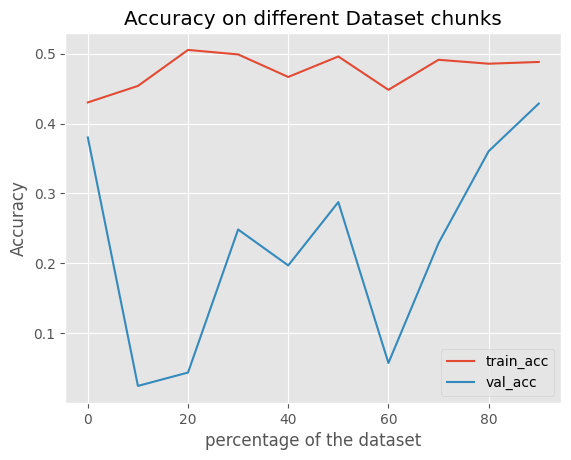

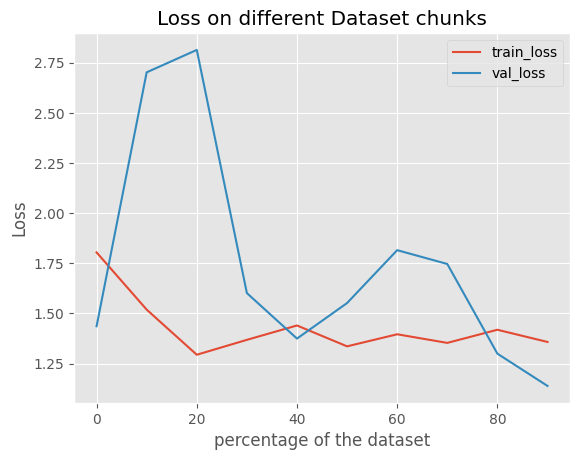

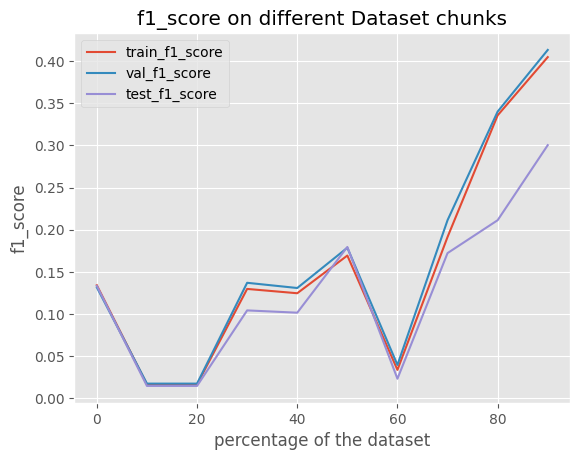

In [32]:
# This should only be run when the model is training on different chunks of the dataset
# plot accuracy and loss lists

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100, 10), accuracy_list, label="train_acc")
plt.plot(np.arange(0, 100, 10), val_accuracy_list, label="val_acc")
plt.title("Accuracy on different Dataset chunks")
plt.xlabel("percentage of the dataset")
plt.ylabel("Accuracy") 
plt.legend()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100, 10), loss_list, label="train_loss")
plt.plot(np.arange(0, 100, 10), val_loss_list, label="val_loss")
plt.title("Loss on different Dataset chunks")
plt.xlabel("percentage of the dataset")
plt.ylabel("Loss") 
plt.legend()

# plot f1 score lists
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100, 10), f1_score_list, label="train_f1_score")
plt.plot(np.arange(0, 100, 10), val_f1_score_list, label="val_f1_score")
plt.plot(np.arange(0, 100, 10), test_f1_score_list, label="test_f1_score")
plt.title("f1_score on different Dataset chunks")
plt.xlabel("percentage of the dataset")
plt.ylabel("f1_score")
plt.legend()

In [48]:
# The model's training process with fixed hyperparameters is defined below
import tensorflow as tf

NUM_EPOCHS = 10
# 20
INIT_LR = 0.001
BS = 64
decay_steps = trainX.shape[0] // BS
decay_rate = 0.5

labelNames = speed_limits

# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# initialize the optimizer and compile the model
print("[INFO] compiling model...")


# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=decay_steps,
    decay_rate=decay_rate)

opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)
model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Save checkpoints
checkpoint_filepath = 'model_trafficSignNet/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(valX, valY),
    steps_per_epoch=trainX.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=2, 
    callbacks=[model_checkpoint_callback])

[INFO] compiling model...
[INFO] training network...
Epoch 1/10
217/217 - 16s - loss: 4.6265 - accuracy: 0.1463 - val_loss: 2.3401 - val_accuracy: 0.1172 - 16s/epoch - 74ms/step
Epoch 2/10
217/217 - 13s - loss: 4.1066 - accuracy: 0.1700 - val_loss: 2.4081 - val_accuracy: 0.0942 - 13s/epoch - 62ms/step
Epoch 3/10
217/217 - 14s - loss: 3.7922 - accuracy: 0.1808 - val_loss: 2.1938 - val_accuracy: 0.1134 - 14s/epoch - 62ms/step
Epoch 4/10
217/217 - 14s - loss: 3.7660 - accuracy: 0.1750 - val_loss: 2.0511 - val_accuracy: 0.2028 - 14s/epoch - 62ms/step
Epoch 5/10
217/217 - 13s - loss: 3.6218 - accuracy: 0.1835 - val_loss: 1.9247 - val_accuracy: 0.2444 - 13s/epoch - 62ms/step
Epoch 6/10
217/217 - 13s - loss: 3.5694 - accuracy: 0.1852 - val_loss: 1.9181 - val_accuracy: 0.2424 - 13s/epoch - 61ms/step
Epoch 7/10
217/217 - 14s - loss: 3.6297 - accuracy: 0.1889 - val_loss: 1.9141 - val_accuracy: 0.2510 - 14s/epoch - 62ms/step
Epoch 8/10
217/217 - 13s - loss: 3.5945 - accuracy: 0.1893 - val_loss: 1

_e10_decay0_5_lr0_001_bs64
accuracy 0.19096745550632477
validation accuracy 0.25502583384513855
loss 3.563932180404663
validation loss 1.908549189567566
436/436 [==============================] - 5s 11ms/step
f1_score 0.2394062749174758
109/109 [==============================] - 1s 11ms/step
validation f1_score 0.2394291186892099


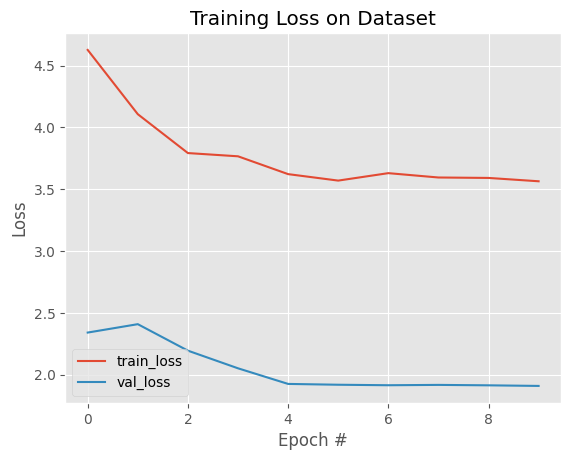

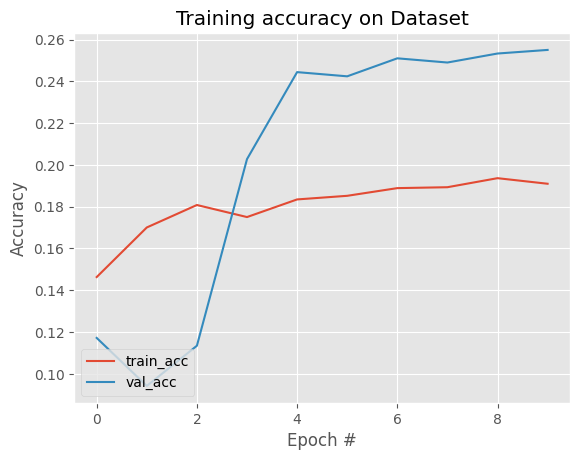

In [49]:
# The plots are saved in the folder 'plots'
import os

if not os.path.exists("plots"):
    os.makedirs("plots")

print('_e' + str(NUM_EPOCHS) + '_decay0_' + str(decay_rate).split('.')[1] + '_lr0_' + str(INIT_LR).split('.')[1] + '_bs' + str(BS))

# plot the 'training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('plots/loss__e' + str(NUM_EPOCHS) + '_decay0_' + str(decay_rate).split('.')[1] + '_lr0_' + str(INIT_LR).split('.')[1] + '_bs' + str(BS))

plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig('plots/accuracy_e' + str(NUM_EPOCHS) + '_decay0_' + str(decay_rate).split('.')[1] + '_lr0_' + str(INIT_LR).split('.')[1] + '_bs' + str(BS))

# Plot last accuracy and loss
print("accuracy", H.history["accuracy"][-1])
print("validation accuracy", H.history["val_accuracy"][-1])
print("loss", H.history["loss"][-1])
print("validation loss", H.history["val_loss"][-1])

# F1 score
from sklearn.metrics import f1_score
print("f1_score", f1_score(trainY.argmax(axis=1), model.predict(trainX).argmax(axis=1), average='macro'))
print("validation f1_score", f1_score(valY.argmax(axis=1), model.predict(valX).argmax(axis=1), average='macro'))

In [50]:
# Save your model
model.save('model_trafficSignNet/model_TrafficSignNet_speedSign_100k.h5', save_format='h5')

In [52]:
from keras.models import load_model

# Load the saved model
# model = load_model('model_trafficSignNet/best_model.h5')
# model = load_model('model_trafficSignNet/model_TrafficSignNet.h5')
# model = load_model('model_trafficSignNet/best_model_GridSearch.h5')
model = load_model('model_trafficSignNet/model_TrafficSignNet_speedSign.h5')

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames, labels=np.arange(0, 43)))

# F1 score
# from sklearn.metrics import f1_score
print("test f1 score", f1_score(testY.argmax(axis=1), model.predict(testX).argmax(axis=1), average='macro'))
print("f1_score", f1_score(test_EVO_Y.argmax(axis=1), model.predict(test_EVO_X).argmax(axis=1), average='macro'))
print("f1_score", f1_score(test_Y_carla.argmax(axis=1), model.predict(test_X_carla).argmax(axis=1), average='macro'))

[INFO] evaluating network...
66/66 [==============================] - 1s 16ms/step
                       precision    recall  f1-score   support

 Speed limit (20km/h)       0.11      0.43      0.18        60
 Speed limit (30km/h)       0.43      0.42      0.42       720
 Speed limit (50km/h)       0.22      0.34      0.27       750
 Speed limit (60km/h)       0.14      0.65      0.23       450
 Speed limit (70km/h)       0.00      0.00      0.00       660
 Speed limit (80km/h)       0.00      0.00      0.00       630
 Speed limit (90km/h)       0.00      0.00      0.00         0
Speed limit (100km/h)       0.00      0.00      0.00       450
Speed limit (120km/h)       0.00      0.00      0.00       450

            micro avg       0.21      0.21      0.21      4170
            macro avg       0.02      0.04      0.03      4170
         weighted avg       0.13      0.21      0.15      4170

 12/131 [=>............................] - ETA: 1s

d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:2326: UserWarning: labels size, 43, does not match size of target_names, 9
  warnings.warn(
d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\carla_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

131/131 [==============================] - 1s 11ms/step
test f1 score 0.1379637927304723
2/2 [==============================] - 0s 5ms/step
f1_score 0.03571428571428571
12/12 [==============================] - 0s 10ms/step
f1_score 0.09798657718120805


In [10]:
from imutils import paths


# load the traffic sign recognizer model
print("[INFO] loading model...")
# model = load_model("model_trafficSignNet/best_model.h5")

# grab the paths to the input images, shuffle them, and grab a sample
print("[INFO] predicting...")
# imagePaths = list(paths.list_images("images\EVO\\Test"))
# random.shuffle(imagePaths)
# imagePaths = imagePaths[:]

# loop over csv file
# open csv file
csvPath = os.path.sep.join(["images\carla", "labels.csv"])
rows = open(csvPath).read().strip().split("\n")[1:]

# initialize the list of data and labels
imagePaths = []
labelsImage = []
for row in rows:
    (label, imagePath) = row.strip().split(",")[-2:]
    imagePath = os.path.sep.join(["images/carla", imagePath])
    imagePaths.append(imagePath)
    labelsImage.append(label)

imagePaths = imagePaths[:1]

# random.shuffle(imagePaths)
# random.shuffle(labelsImage)

[INFO] loading model...
[INFO] predicting...


In [11]:
# Final testing on new images

import imutils
import cv2

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the image, resize it to 32x32 pixels, and then apply
	# Contrast Limited Adaptive Histogram Equalization (CLAHE),
	# just like we did during training
	image = io.imread(imagePath)
	image = transform.resize(image, (32, 32))
	# image = exposure.equalize_adapthist(image, clip_limit=0.1)
	# preprocess the image by scaling it to the range [0, 1]
	image = image.astype("float32") / 255.0
	image = np.expand_dims(image, axis=0)
	# make predictions using the traffic sign recognizer CNN
	preds = model.predict(image)
	j = preds.argmax(axis=1)[0]
	label = labelNames[j]
	# load the image using OpenCV, resize it, and draw the label
	# on it
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=128)
	cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
		0.45, (0, 0, 255), 2)
	# save the image to disk
	p = os.path.sep.join(["images/carla/", "{}.png".format(i)])
	cv2.imwrite(p, image)
	print("[INFO] predicted: {}".format(labelNames[j]), ", ground truth: {}".format(labelsImage[i]))

1/1 [==============================] - 0s 29ms/step
[INFO] predicted: Speed limit (70km/h) , ground truth: 3
